### Import libraries

In [1]:
import tensorflow as tf
from tensorflow.keras.utils import to_categorical
from sklearn.datasets import fetch_openml
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

### Fetch the jet tagging dataset from Open ML

In [2]:
data = fetch_openml('hls4ml_lhc_jets_hlf')
X, y = data['data'], data['target']
le = LabelEncoder()
y = le.fit_transform(y)
y = to_categorical(y, 5)
X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
scaler = StandardScaler()
X_train_val = scaler.fit_transform(X_train_val)
X_test = scaler.transform(X_test)

### Construct a model
This time we're going to use QKeras layers.
QKeras is "Quantized Keras" for deep heterogeneous quantization of ML models.

https://github.com/google/qkeras

It is maintained by Google and we recently added support for QKeras model to hls4ml.

In [3]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l1
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.layers import Activation
from qkeras.qlayers import QDense, QActivation
from qkeras.quantizers import quantized_bits, quantized_relu

We're using `QDense` layer instead of `Dense`, and `QActivation` instead of `Activation`. We're also specifying `kernel_quantizer = quantized_bits(6,0,0)`. This will use 6-bits (of which 0 are integer) for the weights. We also use the same quantization for the biases, and `quantized_relu(6)` for 6-bit ReLU activations.

In [4]:
def qkeras_three_layer_model(ninputs, nclasses, l1Reg=0, name='model_2'):
    model = Sequential(name=name)
    model.add(QDense(64, input_shape=(ninputs,), name='fc1',
                     kernel_quantizer=quantized_bits(6,0,alpha=1), bias_quantizer=quantized_bits(6,0,alpha=1),
                     kernel_initializer='lecun_uniform', kernel_regularizer=l1(l1Reg)))
    model.add(QActivation(activation=quantized_relu(6), name='relu1'))
    model.add(QDense(32, name='fc2',
                     kernel_quantizer=quantized_bits(6,0,alpha=1), bias_quantizer=quantized_bits(6,0,alpha=1),
                     kernel_initializer='lecun_uniform', kernel_regularizer=l1(l1Reg)))
    model.add(QActivation(activation=quantized_relu(6), name='relu2'))
    model.add(QDense(32, name='fc3',
                     kernel_quantizer=quantized_bits(6,0,alpha=1), bias_quantizer=quantized_bits(6,0,alpha=1),
                     kernel_initializer='lecun_uniform', kernel_regularizer=l1(l1Reg)))
    model.add(QActivation(activation=quantized_relu(6), name='relu3'))
    model.add(QDense(nclasses, name='output',
                     kernel_quantizer=quantized_bits(6,0,alpha=1), bias_quantizer=quantized_bits(6,0,alpha=1),
                     kernel_initializer='lecun_uniform', kernel_regularizer=l1(l1Reg)))
    model.add(Activation(activation='softmax', name='softmax'))
    return model

### Train the model with sparsity
We'll use the same settings as the model for part 1: Adam optimizer with categorical crossentropy loss.
We will train with model sparsity, since QKeras layers are prunable.
The model isn't very complex, so this should just take a few minutes even on the CPU.
If you've restarted the notebook kernel after training once, set `train = False` to load the trained model rather than training again.

In [5]:
train = False
if train:
    qkeras_model = qkeras_three_layer_model(X_train_val.shape[1], y_train_val.shape[1], l1Reg=0.0001)

    from tensorflow_model_optimization.python.core.sparsity.keras import prune, pruning_callbacks, pruning_schedule
    from tensorflow_model_optimization.sparsity.keras import strip_pruning
    pruning_params = {"pruning_schedule" : pruning_schedule.ConstantSparsity(0.75, begin_step=2000, frequency=100)}
    
    qkeras_model = prune.prune_low_magnitude(qkeras_model, **pruning_params)

    qkeras_model.compile(optimizer='adam', loss=['categorical_crossentropy'], metrics=['accuracy'])
    callbacks = [pruning_callbacks.UpdatePruningStep()]
    model.fit(X_train_val, y_train_val, batch_size=1024,
              epochs=30, validation_split=0.25, shuffle=True,
              callbacks = callbacks)
    
    # Save the model again but with the pruning 'stripped' to use the regular layer types
    qkeras_model = strip_pruning(model)
    qkeras_model.save('qkeras_3layer.h5',overwrite=True)
    y_qkeras = qkeras_model.predict(X_test)
    
else:
    from tensorflow.keras.models import load_model
    from qkeras.utils import _add_supported_quantized_objects
    co = {}
    _add_supported_quantized_objects(co)
    qkeras_model = load_model('qkeras_3layer.h5', custom_objects=co)
    y_qkeras = qkeras_model.predict(X_test)

## Check performance
How does this model which was trained using 6-bits, and 75% sparsity model compare against the original model? Let's report the accuracy and make a ROC curve. The quantized, pruned model is shown with solid lines, the unpruned model from part 1 is shown with dashed lines.


We should also check that hls4ml can respect the choice to use 6-bits throughout the model, and match the accuracy. We'll generate a configuration from this Quantized model, and plot its performance as the dotted line.
The generated configuration is printed out. You'll notice that it uses 7 bits for the type, but we specified 6!? That's just because QKeras doesn't count the sign-bit when we specify the number of bits, so the type that actually gets used needs 1 more.

We also use the `OutputRoundingSaturationMode` optimizer pass of `hls4ml` to set the Activation layers to round, rather than truncate, the cast. This is important for getting good model accuracy when using small bit precision activations. And we'll set a different data type for the tables used in the Softmax, just for a bit of extra performance.


**Make sure you've trained the model from part 1**

In [6]:
import hls4ml
hls4ml.model.optimizer.OutputRoundingSaturationMode.layers = ['Activation']
hls4ml.model.optimizer.OutputRoundingSaturationMode.rounding_mode = 'AP_RND'
hls4ml.model.optimizer.OutputRoundingSaturationMode.saturation_mode = 'AP_SAT'

config = hls4ml.utils.config_from_keras_model(qkeras_model, granularity='name')
config['LayerName']['softmax']['exp_table_t'] = 'ap_fixed<18,8>'
config['LayerName']['softmax']['inv_table_t'] = 'ap_fixed<18,4>'
print(config)
hls_model = hls4ml.converters.convert_from_keras_model(qkeras_model, hls_config=config, output_dir='hls4ml_qkeras_prj')
hls_model.compile()
y_hls4ml = hls_model.predict(X_test)

Interpreting Sequential
Topology:
Layer name: fc1, layer type: QDense
Layer name: relu1, layer type: QActivation
Layer name: fc2, layer type: QDense
Layer name: relu2, layer type: QActivation
Layer name: fc3, layer type: QDense
Layer name: relu3, layer type: QActivation
Layer name: output, layer type: QDense
Layer name: softmax, layer type: Activation
{'LayerName': {'fc1': {'Precision': {'weight': 'ap_fixed<7,1>', 'bias': 'ap_fixed<7,1>'}, 'ReuseFactor': 1}, 'relu1': {'Precision': {'result': 'ap_fixed<7,1>'}, 'ReuseFactor': 1}, 'fc2': {'Precision': {'weight': 'ap_fixed<7,1>', 'bias': 'ap_fixed<7,1>'}, 'ReuseFactor': 1}, 'relu2': {'Precision': {'result': 'ap_fixed<7,1>'}, 'ReuseFactor': 1}, 'fc3': {'Precision': {'weight': 'ap_fixed<7,1>', 'bias': 'ap_fixed<7,1>'}, 'ReuseFactor': 1}, 'relu3': {'Precision': {'result': 'ap_fixed<7,1>'}, 'ReuseFactor': 1}, 'output': {'Precision': {'weight': 'ap_fixed<7,1>', 'bias': 'ap_fixed<7,1>'}, 'ReuseFactor': 1}, 'softmax': {'Precision': 'ap_fixed<16,6

## Load keras model from previous part

In [7]:
keras_model = load_model('keras_3layer.h5')
y_keras = keras_model.predict(X_test)

### Check ROC

Accuracy keras:  0.7498253012048193
Accuracy qkeras: 0.7636204819277108
Accuracy hls4ml qkeras: 0.7636385542168674


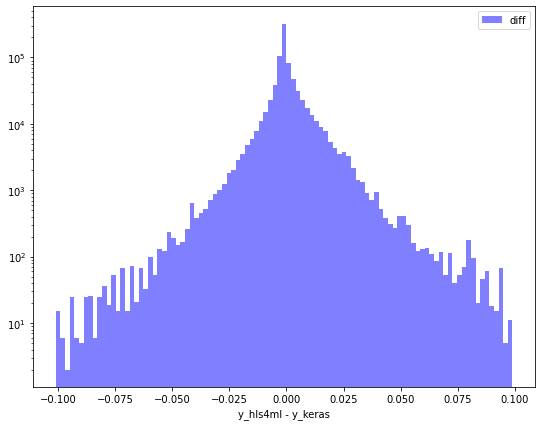

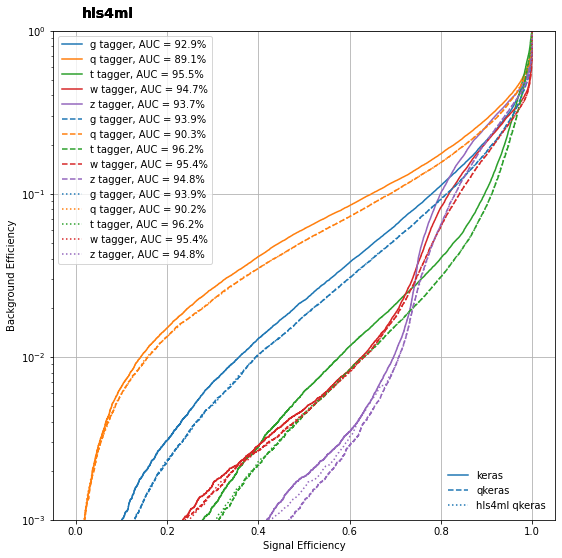

In [11]:
import plotting
from sklearn.metrics import accuracy_score
from tensorflow.keras.models import load_model

fig = plt.figure(figsize=(9, 7))
h, b = np.histogram((y_hls4ml - y_qkeras).flatten(), bins=np.linspace(-0.1,0.1,100))
plt.bar(b[:-1], h, width=b[1]-b[0], color='b', alpha=0.5, label='diff')
plt.legend()
plt.semilogy()
plt.xlabel('y_hls4ml - y_qkeras')
plt.savefig('residual.png')


print("Accuracy keras:  {}".format(accuracy_score(np.argmax(y_test, axis=1), np.argmax(y_keras, axis=1))))
print("Accuracy qkeras: {}".format(accuracy_score(np.argmax(y_test, axis=1), np.argmax(y_qkeras, axis=1))))
print("Accuracy hls4ml qkeras: {}".format(accuracy_score(np.argmax(y_test, axis=1), np.argmax(y_hls4ml, axis=1))))

#ax, = plt.figure(figsize=(9, 9))
fig2, ax = plt.subplots(figsize=(9, 9))
_ = plotting.makeRoc(y_test, y_keras, le.classes_,legend=False)
plt.gca().set_prop_cycle(None) # reset the colors
_ = plotting.makeRoc(y_test, y_qkeras, le.classes_, linestyle='--',legend=False)
plt.gca().set_prop_cycle(None) # reset the colors
_ = plotting.makeRoc(y_test, y_hls4ml, le.classes_, linestyle=':')

from matplotlib.lines import Line2D
lines = [Line2D([0], [0], ls='-'),
         Line2D([0], [0], ls='--'),
         Line2D([0], [0], ls=':')]
from matplotlib.legend import Legend
leg = Legend(ax, lines, labels=['keras', 'qkeras', 'hls4ml qkeras'],
            loc='lower right', frameon=False)
ax.add_artist(leg)

# Synthesize
Now let's synthesize this quantized, pruned model.

**The synthesis will take a while**

In [12]:
hls_model.build()

## Check the reports
Print out the reports generated by Vivado HLS. Pay attention to the Utilization Estimates' section in particular this time.

In [13]:
hls4ml.report.read_vivado_report('hls4ml_qkeras_prj')

Found 1 solution(s) in hls4ml_qkeras_prj/myproject_prj.
Reports for solution "solution1":

C SIMULATION RESULT:
INFO: [SIM 2] *************** CSIM start ***************
INFO: [SIM 4] CSIM will launch GCC as the compiler.
   Compiling ../../../../myproject_test.cpp in debug mode
   Compiling ../../../../firmware/myproject.cpp in debug mode
   Generating csim.exe
INFO: Unable to open input/predictions file, using default input.
0.0214844 0.0888672 0.227539 0.424805 0.257813 
INFO: Saved inference results to file: tb_data/csim_results.log
INFO: [SIM 1] CSim done with 0 errors.
INFO: [SIM 3] *************** CSIM finish ***************

SYNTHESIS REPORT:
== Vivado HLS Report for 'myproject'
* Date:           Fri Jul 10 11:13:11 2020

* Version:        2019.2 (Build 2704478 on Wed Nov 06 22:10:23 MST 2019)
* Project:        myproject_prj
* Solution:       solution1
* Product family: kintexu
* Target device:  xcku115-flvb2104-2-i


== Performance Estimates
+ Timing: 
    * Summary: 
    +----

Print the report for the model trained in part 1. Now, compared to the model from part 1, this model has been trained with low-precision quantization, and 75% pruning. You should be able to see that we have saved a lot of resource compared to where we started in part 1. At the same time, referring to the ROC curve above, the model performance is pretty much identical even with this compression!

**Note you need to have trained and synthesized the model from part 1**

In [14]:
hls4ml.report.read_vivado_report('hls4ml_keras_prj')

Found 1 solution(s) in hls4ml_keras_prj/myproject_prj.
Reports for solution "solution1":

C SIMULATION RESULT:
INFO: [SIM 2] *************** CSIM start ***************
INFO: [SIM 4] CSIM will launch GCC as the compiler.
   Compiling ../../../../myproject_test.cpp in debug mode
   Compiling ../../../../firmware/myproject.cpp in debug mode
   Generating csim.exe
INFO: Unable to open input/predictions file, using default input.
0.0595703 0.22168 0.566406 0.0175781 0.162109 
INFO: Saved inference results to file: tb_data/csim_results.log
INFO: [SIM 1] CSim done with 0 errors.
INFO: [SIM 3] *************** CSIM finish ***************

SYNTHESIS REPORT:
== Vivado HLS Report for 'myproject'
* Date:           Fri Jul 10 10:24:10 2020

* Version:        2019.2 (Build 2704478 on Wed Nov 06 22:10:23 MST 2019)
* Project:        myproject_prj
* Solution:       solution1
* Product family: kintexu
* Target device:  xcku115-flvb2104-2-i


== Performance Estimates
+ Timing: 
    * Summary: 
    +------

## NB
Note as well that the Vivado HLS resource estimates tend to _overestimate_ LUTs, while generally estimating the DSPs correctly. Running the subsequent stages of FPGA compilation reveals the more realistic resource usage, You can run the next step, 'logic synthesis' with `hls_model.build(vsynth=True)`, but we skipped it in this tutorial in the interest of time.